In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.


(32 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
64 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
Dense 256 -> 
PReLU -> 
Dense 256 -> 
PReLU -> 
Dense 2) 

For different datasets we use a network with different number of input channels eg. MNIST or SVHN

<img src="./images/siamese.png" height="422" width="722" >

Contrastive loss function is given by the following :-

$$\mathcal{L}(I_{1}, I_{2}) = y[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]^{2} + (1-y)*ReLU([\mathcal{m}-[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]]^{2})$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import SiameseCD,SiameseMNIST,SiameseSVHN

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Contrastive  Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [9]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        
        #primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        #plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        
        #helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        #plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [25]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.196913
Train: [12800/50000 (26%)]	Loss: 0.128464
Train: [25600/50000 (51%)]	Loss: 0.125726
Train: [38400/50000 (77%)]	Loss: 0.126433
Epoch: 1/20. Train set: Average loss: 0.1268
Epoch: 1/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.125465
Train: [12800/50000 (26%)]	Loss: 0.125240
Train: [25600/50000 (51%)]	Loss: 0.125286
Train: [38400/50000 (77%)]	Loss: 0.125374
Epoch: 2/20. Train set: Average loss: 0.1253
Epoch: 2/20. Validation set: Average loss: 0.1251
Train: [0/50000 (0%)]	Loss: 0.125461
Train: [12800/50000 (26%)]	Loss: 0.125218
Train: [25600/50000 (51%)]	Loss: 0.125159
Train: [38400/50000 (77%)]	Loss: 0.125267
Epoch: 3/20. Train set: Average loss: 0.1252
Epoch: 3/20. Validation set: Average loss: 0.1252
Train: [0/50000 (0%)]	Loss: 0.125789
Train: [12800/50000 (26%)]	Loss: 0.125254
Train: [25600/50000 (51%)]	Loss: 0.125224
Train: [38400/50000 (77%)]	Loss: 0.125408
Epoch: 4/20. Train set: Average loss: 0.1253
Epoch: 4/20. Valid

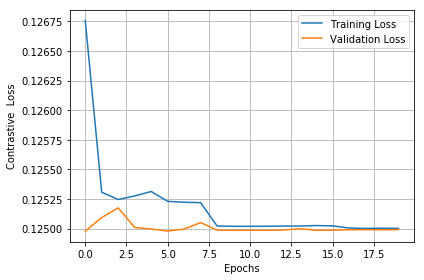

In [26]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

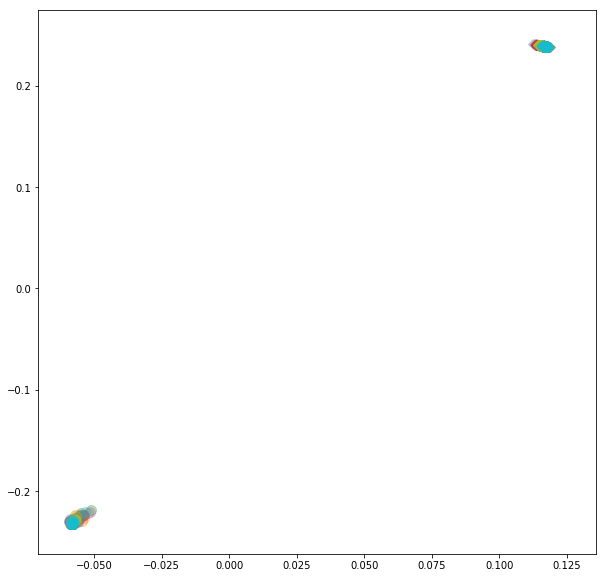

In [27]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)


siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [29]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.177330
Train: [12800/50000 (26%)]	Loss: 0.133245
Train: [25600/50000 (51%)]	Loss: 0.105193
Train: [38400/50000 (77%)]	Loss: 0.069781
Epoch: 1/20. Train set: Average loss: 0.0910
Epoch: 1/20. Validation set: Average loss: 0.0431
Train: [0/50000 (0%)]	Loss: 0.046780
Train: [12800/50000 (26%)]	Loss: 0.037235
Train: [25600/50000 (51%)]	Loss: 0.030571
Train: [38400/50000 (77%)]	Loss: 0.026671
Epoch: 2/20. Train set: Average loss: 0.0301
Epoch: 2/20. Validation set: Average loss: 0.0253
Train: [0/50000 (0%)]	Loss: 0.033651
Train: [12800/50000 (26%)]	Loss: 0.021613
Train: [25600/50000 (51%)]	Loss: 0.018387
Train: [38400/50000 (77%)]	Loss: 0.018201
Epoch: 3/20. Train set: Average loss: 0.0189
Epoch: 3/20. Validation set: Average loss: 0.0198
Train: [0/50000 (0%)]	Loss: 0.010280
Train: [12800/50000 (26%)]	Loss: 0.014123
Train: [25600/50000 (51%)]	Loss: 0.013308
Train: [38400/50000 (77%)]	Loss: 0.013060
Epoch: 4/20. Train set: Average loss: 0.0128
Epoch: 4/20. Valid

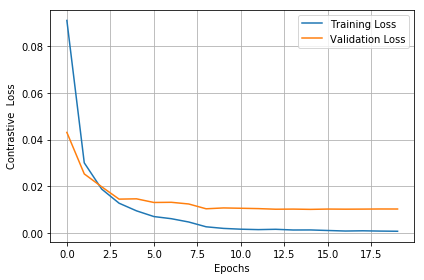

In [30]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

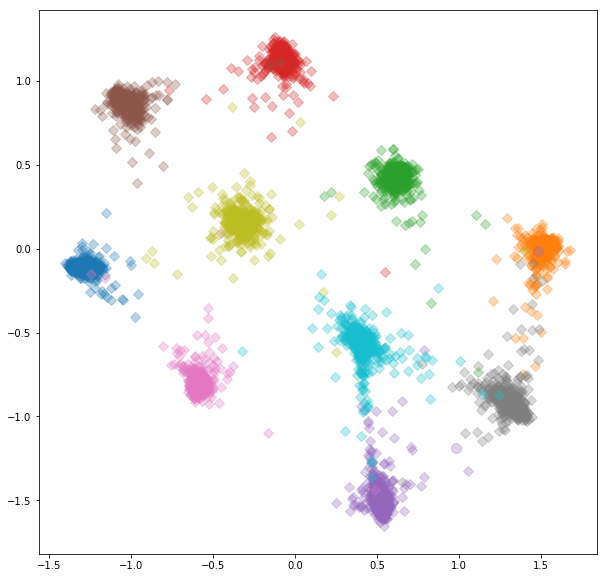

In [35]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

### Online Pair Selection 

 We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.

### MNIST and SVHN 

In [11]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )

In [12]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import OnlineContrastiveLoss2
from utils import AllPositivePairSelector2, HardNegativePairSelector2 # Strategies for selecting pairs within a minibatch
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss2(margin, AllPositivePairSelector2(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 200
log_interval = 50

Train: [0/50000 (0%)]	Loss: 0.375844
Train: [50/50000 (25%)]	Loss: 0.261790
Train: [100/50000 (50%)]	Loss: 0.250363
Train: [150/50000 (75%)]	Loss: 0.250207
Epoch: 1/200. Train set: Average loss: 0.2538
Epoch: 1/200. Validation set: Average loss: 0.2439
Train: [0/50000 (0%)]	Loss: 0.247964
Train: [50/50000 (25%)]	Loss: 0.250300
Train: [100/50000 (50%)]	Loss: 0.250248
Train: [150/50000 (75%)]	Loss: 0.250229
Epoch: 2/200. Train set: Average loss: 0.2502
Epoch: 2/200. Validation set: Average loss: 0.2439
Train: [0/50000 (0%)]	Loss: 0.250566
Train: [50/50000 (25%)]	Loss: 0.250233
Train: [100/50000 (50%)]	Loss: 0.250112
Train: [150/50000 (75%)]	Loss: 0.250296
Epoch: 3/200. Train set: Average loss: 0.2502
Epoch: 3/200. Validation set: Average loss: 0.2439
Train: [0/50000 (0%)]	Loss: 0.249804
Train: [50/50000 (25%)]	Loss: 0.250192
Train: [100/50000 (50%)]	Loss: 0.250075
Train: [150/50000 (75%)]	Loss: 0.250071
Epoch: 4/200. Train set: Average loss: 0.2501
Epoch: 4/200. Validation set: Average l

Train: [100/50000 (50%)]	Loss: 0.250013
Train: [150/50000 (75%)]	Loss: 0.250008
Epoch: 33/200. Train set: Average loss: 0.2500
Epoch: 33/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249948
Train: [50/50000 (25%)]	Loss: 0.249959
Train: [100/50000 (50%)]	Loss: 0.249988
Train: [150/50000 (75%)]	Loss: 0.250037
Epoch: 34/200. Train set: Average loss: 0.2500
Epoch: 34/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250085
Train: [50/50000 (25%)]	Loss: 0.250027
Train: [100/50000 (50%)]	Loss: 0.250028
Train: [150/50000 (75%)]	Loss: 0.249992
Epoch: 35/200. Train set: Average loss: 0.2500
Epoch: 35/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249795
Train: [50/50000 (25%)]	Loss: 0.250026
Train: [100/50000 (50%)]	Loss: 0.250018
Train: [150/50000 (75%)]	Loss: 0.249993
Epoch: 36/200. Train set: Average loss: 0.2500
Epoch: 36/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250066
Train: [50/50000 (2

Train: [150/50000 (75%)]	Loss: 0.250036
Epoch: 65/200. Train set: Average loss: 0.2500
Epoch: 65/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.249982
Train: [50/50000 (25%)]	Loss: 0.249934
Train: [100/50000 (50%)]	Loss: 0.250026
Train: [150/50000 (75%)]	Loss: 0.250022
Epoch: 66/200. Train set: Average loss: 0.2500
Epoch: 66/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249810
Train: [50/50000 (25%)]	Loss: 0.249952
Train: [100/50000 (50%)]	Loss: 0.250017
Train: [150/50000 (75%)]	Loss: 0.249979
Epoch: 67/200. Train set: Average loss: 0.2500
Epoch: 67/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250231
Train: [50/50000 (25%)]	Loss: 0.250045
Train: [100/50000 (50%)]	Loss: 0.250023
Train: [150/50000 (75%)]	Loss: 0.249965
Epoch: 68/200. Train set: Average loss: 0.2500
Epoch: 68/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250236
Train: [50/50000 (25%)]	Loss: 0.249983
Train: [100/50000 (5

Epoch: 97/200. Train set: Average loss: 0.2500
Epoch: 97/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250064
Train: [50/50000 (25%)]	Loss: 0.250006
Train: [100/50000 (50%)]	Loss: 0.250030
Train: [150/50000 (75%)]	Loss: 0.249990
Epoch: 98/200. Train set: Average loss: 0.2500
Epoch: 98/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.249779
Train: [50/50000 (25%)]	Loss: 0.249964
Train: [100/50000 (50%)]	Loss: 0.249999
Train: [150/50000 (75%)]	Loss: 0.250029
Epoch: 99/200. Train set: Average loss: 0.2500
Epoch: 99/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.249898
Train: [50/50000 (25%)]	Loss: 0.250010
Train: [100/50000 (50%)]	Loss: 0.249986
Train: [150/50000 (75%)]	Loss: 0.249977
Epoch: 100/200. Train set: Average loss: 0.2500
Epoch: 100/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250043
Train: [50/50000 (25%)]	Loss: 0.249999
Train: [100/50000 (50%)]	Loss: 0.249986
Train: [150/50000 

Epoch: 129/200. Train set: Average loss: 0.2500
Epoch: 129/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250192
Train: [50/50000 (25%)]	Loss: 0.249992
Train: [100/50000 (50%)]	Loss: 0.250017
Train: [150/50000 (75%)]	Loss: 0.249955
Epoch: 130/200. Train set: Average loss: 0.2500
Epoch: 130/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250215
Train: [50/50000 (25%)]	Loss: 0.249991
Train: [100/50000 (50%)]	Loss: 0.249999
Train: [150/50000 (75%)]	Loss: 0.250026
Epoch: 131/200. Train set: Average loss: 0.2500
Epoch: 131/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250085
Train: [50/50000 (25%)]	Loss: 0.250002
Train: [100/50000 (50%)]	Loss: 0.250025
Train: [150/50000 (75%)]	Loss: 0.249982
Epoch: 132/200. Train set: Average loss: 0.2500
Epoch: 132/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250097
Train: [50/50000 (25%)]	Loss: 0.249957
Train: [100/50000 (50%)]	Loss: 0.249980
Train: [150/

Epoch: 161/200. Train set: Average loss: 0.2500
Epoch: 161/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249934
Train: [50/50000 (25%)]	Loss: 0.250023
Train: [100/50000 (50%)]	Loss: 0.250013
Train: [150/50000 (75%)]	Loss: 0.250050
Epoch: 162/200. Train set: Average loss: 0.2500
Epoch: 162/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249887
Train: [50/50000 (25%)]	Loss: 0.249988
Train: [100/50000 (50%)]	Loss: 0.249991
Train: [150/50000 (75%)]	Loss: 0.250020
Epoch: 163/200. Train set: Average loss: 0.2500
Epoch: 163/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.249931
Train: [50/50000 (25%)]	Loss: 0.250010
Train: [100/50000 (50%)]	Loss: 0.250020
Train: [150/50000 (75%)]	Loss: 0.249977
Epoch: 164/200. Train set: Average loss: 0.2500
Epoch: 164/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.250413
Train: [50/50000 (25%)]	Loss: 0.250004
Train: [100/50000 (50%)]	Loss: 0.250009
Train: [150/

Epoch: 193/200. Train set: Average loss: 0.2500
Epoch: 193/200. Validation set: Average loss: 0.2437
Train: [0/50000 (0%)]	Loss: 0.249879
Train: [50/50000 (25%)]	Loss: 0.250025
Train: [100/50000 (50%)]	Loss: 0.250002
Train: [150/50000 (75%)]	Loss: 0.249980
Epoch: 194/200. Train set: Average loss: 0.2500
Epoch: 194/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250140
Train: [50/50000 (25%)]	Loss: 0.249989
Train: [100/50000 (50%)]	Loss: 0.249978
Train: [150/50000 (75%)]	Loss: 0.249981
Epoch: 195/200. Train set: Average loss: 0.2500
Epoch: 195/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250020
Train: [50/50000 (25%)]	Loss: 0.249992
Train: [100/50000 (50%)]	Loss: 0.249972
Train: [150/50000 (75%)]	Loss: 0.249998
Epoch: 196/200. Train set: Average loss: 0.2500
Epoch: 196/200. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.249962
Train: [50/50000 (25%)]	Loss: 0.250009
Train: [100/50000 (50%)]	Loss: 0.249974
Train: [150/

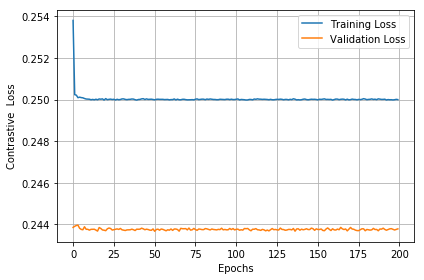

In [13]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='contrastive')
showLossHist(lossDict)

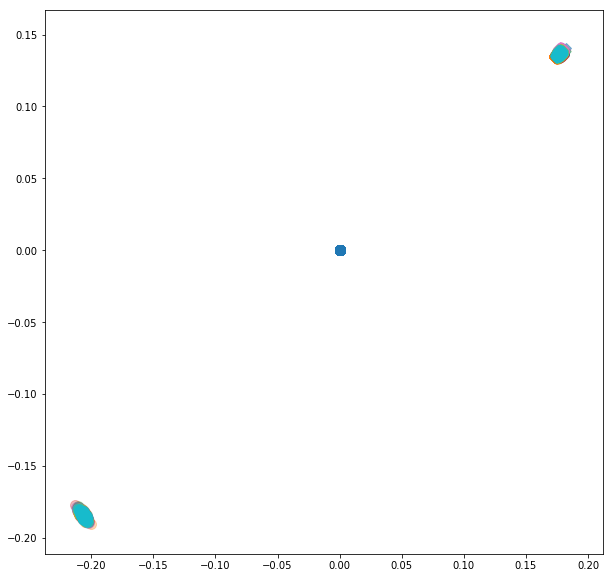

In [16]:
primary_train_embeddings, primary_train_labels = extract_embeddings(online_train_loader_primary, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(online_train_loader_helper, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

In [ ]:
loss_fn = OnlineContrastiveLoss2(margin, HardNegativePairSelector2())
fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='contrastive')

In [ ]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

### MNIST and USPS

In [ ]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )

In [6]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import OnlineContrastiveLoss2
from utils import AllPositivePairSelector2, HardNegativePairSelector2 # Strategies for selecting pairs within a minibatch
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = SiameseNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss2(margin, AllPositivePairSelector2(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 200
log_interval = 50

In [42]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='contrastive')
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.437063
Epoch: 1/200. Train set: Average loss: 0.3210
Epoch: 1/200. Validation set: Average loss: 0.1133
Train: [0/50000 (0%)]	Loss: 0.250995
Epoch: 2/200. Train set: Average loss: 0.2516
Epoch: 2/200. Validation set: Average loss: 0.1133
Train: [0/50000 (0%)]	Loss: 0.244924
Epoch: 3/200. Train set: Average loss: 0.2514
Epoch: 3/200. Validation set: Average loss: 0.1127
Train: [0/50000 (0%)]	Loss: 0.250678
Epoch: 4/200. Train set: Average loss: 0.2503
Epoch: 4/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.251755
Epoch: 5/200. Train set: Average loss: 0.2500
Epoch: 5/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250080
Epoch: 6/200. Train set: Average loss: 0.2495
Epoch: 6/200. Validation set: Average loss: 0.1132
Train: [0/50000 (0%)]	Loss: 0.245563
Epoch: 7/200. Train set: Average loss: 0.2510
Epoch: 7/200. Validation set: Average loss: 0.1107
Train: [0/50000 (0%)]	Loss: 0.243804
Epoch: 8/200. Train set: 

Train: [0/50000 (0%)]	Loss: 0.152422
Epoch: 62/200. Train set: Average loss: 0.1550
Epoch: 62/200. Validation set: Average loss: 0.0675
Train: [0/50000 (0%)]	Loss: 0.176046
Epoch: 63/200. Train set: Average loss: 0.1561
Epoch: 63/200. Validation set: Average loss: 0.0698
Train: [0/50000 (0%)]	Loss: 0.161039
Epoch: 64/200. Train set: Average loss: 0.1562
Epoch: 64/200. Validation set: Average loss: 0.0665
Train: [0/50000 (0%)]	Loss: 0.172490
Epoch: 65/200. Train set: Average loss: 0.1511
Epoch: 65/200. Validation set: Average loss: 0.0696
Train: [0/50000 (0%)]	Loss: 0.162746
Epoch: 66/200. Train set: Average loss: 0.1562
Epoch: 66/200. Validation set: Average loss: 0.0673
Train: [0/50000 (0%)]	Loss: 0.173303
Epoch: 67/200. Train set: Average loss: 0.1510
Epoch: 67/200. Validation set: Average loss: 0.0689
Train: [0/50000 (0%)]	Loss: 0.179198
Epoch: 68/200. Train set: Average loss: 0.1521
Epoch: 68/200. Validation set: Average loss: 0.0688
Train: [0/50000 (0%)]	Loss: 0.145686
Epoch: 69/2

Train: [0/50000 (0%)]	Loss: 0.145220
Epoch: 122/200. Train set: Average loss: 0.1464
Epoch: 122/200. Validation set: Average loss: 0.0715
Train: [0/50000 (0%)]	Loss: 0.141524
Epoch: 123/200. Train set: Average loss: 0.1538
Epoch: 123/200. Validation set: Average loss: 0.0712
Train: [0/50000 (0%)]	Loss: 0.172207
Epoch: 124/200. Train set: Average loss: 0.1586
Epoch: 124/200. Validation set: Average loss: 0.0683
Train: [0/50000 (0%)]	Loss: 0.122184
Epoch: 125/200. Train set: Average loss: 0.1507
Epoch: 125/200. Validation set: Average loss: 0.0692
Train: [0/50000 (0%)]	Loss: 0.126826
Epoch: 126/200. Train set: Average loss: 0.1514
Epoch: 126/200. Validation set: Average loss: 0.0674
Train: [0/50000 (0%)]	Loss: 0.151693
Epoch: 127/200. Train set: Average loss: 0.1538
Epoch: 127/200. Validation set: Average loss: 0.0695
Train: [0/50000 (0%)]	Loss: 0.135556
Epoch: 128/200. Train set: Average loss: 0.1534
Epoch: 128/200. Validation set: Average loss: 0.0681
Train: [0/50000 (0%)]	Loss: 0.1616

Train: [0/50000 (0%)]	Loss: 0.173854
Epoch: 182/200. Train set: Average loss: 0.1523
Epoch: 182/200. Validation set: Average loss: 0.0682
Train: [0/50000 (0%)]	Loss: 0.146471
Epoch: 183/200. Train set: Average loss: 0.1535
Epoch: 183/200. Validation set: Average loss: 0.0701
Train: [0/50000 (0%)]	Loss: 0.168560
Epoch: 184/200. Train set: Average loss: 0.1561
Epoch: 184/200. Validation set: Average loss: 0.0694
Train: [0/50000 (0%)]	Loss: 0.137983
Epoch: 185/200. Train set: Average loss: 0.1581
Epoch: 185/200. Validation set: Average loss: 0.0687
Train: [0/50000 (0%)]	Loss: 0.164972
Epoch: 186/200. Train set: Average loss: 0.1543
Epoch: 186/200. Validation set: Average loss: 0.0672
Train: [0/50000 (0%)]	Loss: 0.154508
Epoch: 187/200. Train set: Average loss: 0.1513
Epoch: 187/200. Validation set: Average loss: 0.0676
Train: [0/50000 (0%)]	Loss: 0.143654
Epoch: 188/200. Train set: Average loss: 0.1585
Epoch: 188/200. Validation set: Average loss: 0.0675
Train: [0/50000 (0%)]	Loss: 0.1652

{'trainLoss': [0.32095469948318267,
  0.2515975700484382,
  0.2513915076851845,
  0.2503156223230892,
  0.2500494842727979,
  0.24947560247447756,
  0.2509591082731883,
  0.23749332792229122,
  0.20080558790100944,
  0.19784648964802423,
  0.1856272667646408,
  0.17798556801345614,
  0.1669630292389128,
  0.16704301950004366,
  0.16131126880645752,
  0.158433488673634,
  0.1631714486413532,
  0.1551607276002566,
  0.1515086433953709,
  0.15571627103620106,
  0.15176286879512998,
  0.15307108643982145,
  0.15068983617756102,
  0.15403294728861916,
  0.1572874668571684,
  0.15547238538662592,
  0.15494475016991296,
  0.1508397509654363,
  0.1550005873044332,
  0.15717502848969567,
  0.15487772309117848,
  0.15368846472766665,
  0.15225685884555182,
  0.15528220683336258,
  0.15843910806708866,
  0.15761321783065796,
  0.15124183313714135,
  0.15335632446739408,
  0.15430464098850885,
  0.14813121408224106,
  0.15071842653883827,
  0.15699196855227152,
  0.1521200570795271,
  0.1544731913

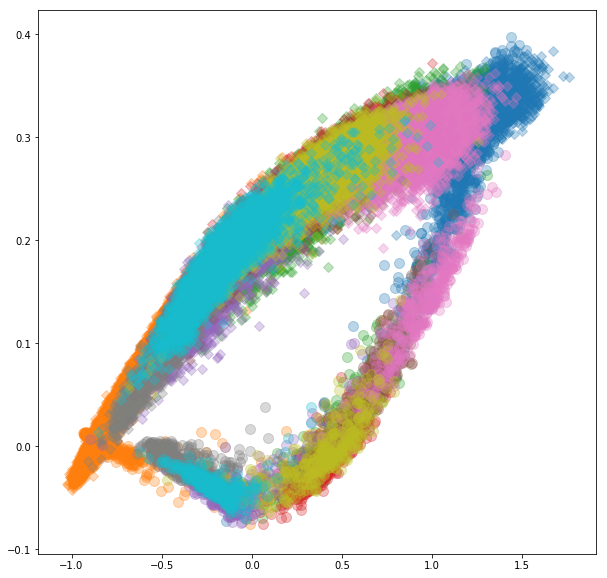

In [43]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

In [7]:
loss_fn = OnlineContrastiveLoss2(margin, HardNegativePairSelector2())
fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='contrastive')

Train: [0/50000 (0%)]	Loss: 0.373991
Epoch: 1/200. Train set: Average loss: 0.3331
Epoch: 1/200. Validation set: Average loss: 0.1153
Train: [0/50000 (0%)]	Loss: 0.256794
Epoch: 2/200. Train set: Average loss: 0.2545
Epoch: 2/200. Validation set: Average loss: 0.1134
Train: [0/50000 (0%)]	Loss: 0.252215
Epoch: 3/200. Train set: Average loss: 0.2523
Epoch: 3/200. Validation set: Average loss: 0.1135
Train: [0/50000 (0%)]	Loss: 0.252546
Epoch: 4/200. Train set: Average loss: 0.2517
Epoch: 4/200. Validation set: Average loss: 0.1131
Train: [0/50000 (0%)]	Loss: 0.250926
Epoch: 5/200. Train set: Average loss: 0.2512
Epoch: 5/200. Validation set: Average loss: 0.1131
Train: [0/50000 (0%)]	Loss: 0.252143
Epoch: 6/200. Train set: Average loss: 0.2513
Epoch: 6/200. Validation set: Average loss: 0.1131
Train: [0/50000 (0%)]	Loss: 0.251253
Epoch: 7/200. Train set: Average loss: 0.2510
Epoch: 7/200. Validation set: Average loss: 0.1131
Train: [0/50000 (0%)]	Loss: 0.251935
Epoch: 8/200. Train set: 

Train: [0/50000 (0%)]	Loss: 0.250082
Epoch: 62/200. Train set: Average loss: 0.2503
Epoch: 62/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250045
Epoch: 63/200. Train set: Average loss: 0.2502
Epoch: 63/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.249693
Epoch: 64/200. Train set: Average loss: 0.2503
Epoch: 64/200. Validation set: Average loss: 0.1127
Train: [0/50000 (0%)]	Loss: 0.250225
Epoch: 65/200. Train set: Average loss: 0.2502
Epoch: 65/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.249638
Epoch: 66/200. Train set: Average loss: 0.2503
Epoch: 66/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250482
Epoch: 67/200. Train set: Average loss: 0.2503
Epoch: 67/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250121
Epoch: 68/200. Train set: Average loss: 0.2503
Epoch: 68/200. Validation set: Average loss: 0.1127
Train: [0/50000 (0%)]	Loss: 0.250395
Epoch: 69/2

Train: [0/50000 (0%)]	Loss: 0.250548
Epoch: 122/200. Train set: Average loss: 0.2504
Epoch: 122/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250115
Epoch: 123/200. Train set: Average loss: 0.2502
Epoch: 123/200. Validation set: Average loss: 0.1127
Train: [0/50000 (0%)]	Loss: 0.250148
Epoch: 124/200. Train set: Average loss: 0.2502
Epoch: 124/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250348
Epoch: 125/200. Train set: Average loss: 0.2503
Epoch: 125/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250786
Epoch: 126/200. Train set: Average loss: 0.2503
Epoch: 126/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250382
Epoch: 127/200. Train set: Average loss: 0.2502
Epoch: 127/200. Validation set: Average loss: 0.1127
Train: [0/50000 (0%)]	Loss: 0.250036
Epoch: 128/200. Train set: Average loss: 0.2502
Epoch: 128/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.2504

Train: [0/50000 (0%)]	Loss: 0.250066
Epoch: 182/200. Train set: Average loss: 0.2503
Epoch: 182/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250341
Epoch: 183/200. Train set: Average loss: 0.2503
Epoch: 183/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250805
Epoch: 184/200. Train set: Average loss: 0.2504
Epoch: 184/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.249955
Epoch: 185/200. Train set: Average loss: 0.2502
Epoch: 185/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250574
Epoch: 186/200. Train set: Average loss: 0.2504
Epoch: 186/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250113
Epoch: 187/200. Train set: Average loss: 0.2502
Epoch: 187/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.250729
Epoch: 188/200. Train set: Average loss: 0.2504
Epoch: 188/200. Validation set: Average loss: 0.1126
Train: [0/50000 (0%)]	Loss: 0.2504

{'trainLoss': [0.33308060467243195,
  0.2544923341936535,
  0.25225768321090275,
  0.2517403331067827,
  0.25123931136396194,
  0.2512529194355011,
  0.25102930929925704,
  0.25096355709764695,
  0.2509941342804167,
  0.2505743246939447,
  0.25041939649317,
  0.25030574864811367,
  0.250545231004556,
  0.25042374928792316,
  0.2503342032432556,
  0.25029837008979583,
  0.25036356929275727,
  0.25044482201337814,
  0.250373524096277,
  0.2502546020680004,
  0.2503126569920116,
  0.25037208447853726,
  0.25021763890981674,
  0.25032877094215816,
  0.2503272286719746,
  0.25032982809676063,
  0.25037555396556854,
  0.25030319806602264,
  0.2502750919924842,
  0.2502066261238522,
  0.25040187024407917,
  0.2501782319611973,
  0.2503140750858519,
  0.250292692747381,
  0.25033582250277203,
  0.25028735895951587,
  0.25028133971823585,
  0.25033888551923966,
  0.25015560123655534,
  0.2503710604376263,
  0.2502555027604103,
  0.2502297419640753,
  0.2501789952317874,
  0.25034865405824447,
 

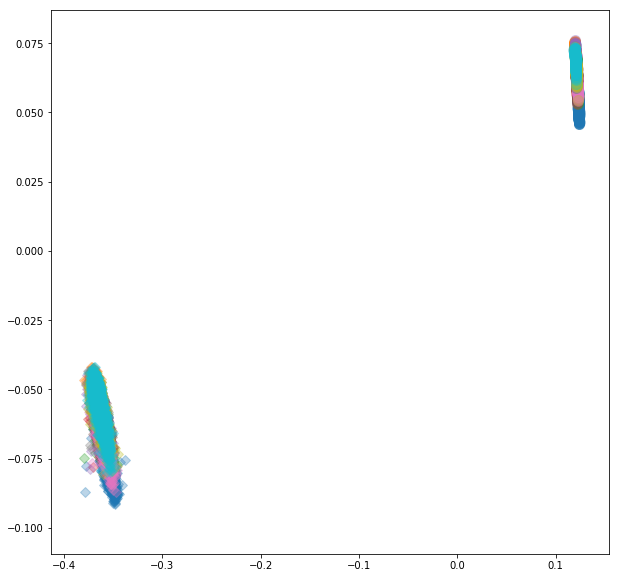

In [10]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)